In [2]:
import numpy as np
import torch
import argparse
import os

import utils
import m3td3

from IPython.display import clear_output
import matplotlib.pyplot as plt

from env import envs

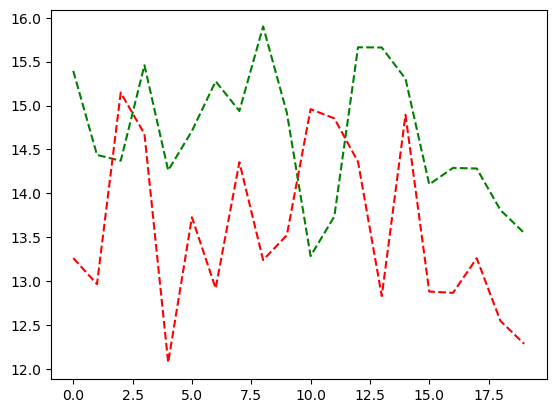

iterations: 10000


KeyboardInterrupt: 

In [4]:
if __name__ == "__main__":
	
	parser = argparse.ArgumentParser()
	parser.add_argument("--policy", default="TD3")                  # Policy name (TD3, DDPG or OurDDPG)
	parser.add_argument("--env", default="HalfCheetah-v2")          # OpenAI gym environment name
	parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
	parser.add_argument("--start_timesteps", default=1e4, type=int)# Time steps initial random policy is used
	parser.add_argument("--eval_freq", default=5e3, type=int)       # How often (time steps) we evaluate
	parser.add_argument("--max_timesteps", default=1e6, type=int)   # Max time steps to run environment
	parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
	parser.add_argument("--batch_size", default=256, type=int)      # Batch size for both actor and critic
	parser.add_argument("--discount", default=0.99)                 # Discount factor
	parser.add_argument("--tau", default=0.005)                     # Target network update rate
	parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
	parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
	parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
	parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
	parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
	args = parser.parse_args(args=[])

	file_name = f"{args.policy}_{args.env}_{args.seed}"
	print("---------------------------------------")
	print(f"Policy: {args.policy}, Env: {args.env}, Seed: {args.seed}")
	print("---------------------------------------")
	
	if not os.path.exists("./results"):
		os.makedirs("./results")

	if args.save_model and not os.path.exists("./models"):
		os.makedirs("./models")
	
	env= envs()
	


	state_dim =  env.states.shape[1]
	action_dim = 11
	num_agent = 2
	max_action = 1.0
	num_agent = 2
	
	kwargs = {
		"state_dim": state_dim,
		"action_dim": action_dim,
		"max_action": max_action,
		"discount": args.discount,
		"tau": args.tau,
	}

	# Initialize policy
	if args.policy == "TD3":
		# Target policy smoothing is scaled wrt the action scale
		kwargs["policy_noise"] = args.policy_noise * max_action
		kwargs["noise_clip"] = args.noise_clip * max_action
		kwargs["policy_freq"] = args.policy_freq
		policy = m3td3.TD3(**kwargs)

	if args.load_model != "":
		policy_file = file_name if args.load_model == "default" else args.load_model
		policy.load(f"./models/{policy_file}")

	replay_buffer = utils.ReplayBuffer(num_agent, state_dim, action_dim)
	
	state_n, done = env.states, False
	episode_reward = 0
	episode_timesteps = 0
	episode_num = 0
	rewards_mean_list_ev1 = []
	rewards_list_ev1 = []
	rewards_mean_list_ev2 = []
	rewards_list_ev2 = []
	grad_mean_list_ev = []
	grad_list_ev = []
	ag =0
	pr_list = []
	load_list = []
	action_list = []
	state_list = []

	for t in range(150000):
		
		episode_timesteps += 1

		# Select action randomly or according to policy
		if t < args.start_timesteps:
			action_n = (-1 + 2*np.random.rand(num_agent,action_dim))
		else:
			action_n = (policy.sample_action(np.array(state_n))
				+ np.random.normal(0, max_action * args.expl_noise, size=action_dim)
			).clip(-max_action, max_action)


		# Perform action
		reward_n, next_state_n, Pr, load = env.step(action_n, t) 
		done_bool = np.vstack((0, 0))

		# Store data in replay buffer
		replay_buffer.add(state_n, action_n, next_state_n, reward_n, done_bool)
		state_list.append(state_n)
		action_list.append(action_n)

		state_n = next_state_n


		# Train agent after collecting sufficient data
		if t >= args.start_timesteps:
			policy.train(replay_buffer, args.batch_size)

		pr_list.append(Pr)
		load_list.append(load)
		# Train agent after collecting sufficient data
		rewards_list_ev1.append(reward_n[0])
		rewards_list_ev2.append(reward_n[1])
		if (t+1)%500 == 0:
			rewards_array_ev1 = np.array(rewards_list_ev1)
			rewards_mean_ev1 = rewards_array_ev1.mean(axis = 0)
			rewards_mean_list_ev1.append(rewards_mean_ev1)
			rewards_list_ev1 = []		

			rewards_array_ev2 = np.array(rewards_list_ev2)
			rewards_mean_ev2 = rewards_array_ev2.mean(axis = 0)
			rewards_mean_list_ev2.append(rewards_mean_ev2)
			rewards_list_ev2 = []	

		if (t+1)%500 == 0:
			print('action', action_n)
			print('reward', reward_n)
			print('--------------')
			

		if (t+1)%2000  == 0:
			clear_output()
			rewards_mean_array_ev1 = np.array(rewards_mean_list_ev1)
			# print(rewards_mean_array_ev1[:10])
			x = range(rewards_mean_array_ev1.shape[0])
			y1 = rewards_mean_array_ev1
			rewards_mean_array_ev2 = np.array(rewards_mean_list_ev2)
			x = range(rewards_mean_array_ev2.shape[0])
			y2 = rewards_mean_array_ev2
			plt.plot( x, y1, 'g--', y2, 'r--')
			plt.show()
		
			print('iterations:', t+1)



In [3]:
action_n.shape

(2, 11)

In [3]:
from scipy.io import savemat
mdic = {"agent1": y1, "agent2": y2}
savemat("training2agent2_non.mat", mdic)

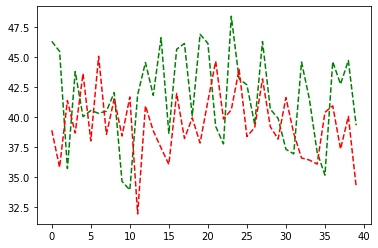

iterations: 20000
action [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.]]
reward [[57.44716793]
 [50.12020896]]
--------------
action [[ 1.          1.          1.          1.          1.          1.
   0.9999935   1.          1.          0.97413445 -1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.         -1.        ]]
reward [[53.95316888]
 [52.9214575 ]]
--------------


KeyboardInterrupt: 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in range(num_agent):
    policy.agents[i].actor.eval()
episode_reward = 0
episode_timesteps = 0
episode_num = 0
rewards_mean_list_ev1 = []
rewards_long_list_ev1 = []
rewards_list_ev1 = []
rewards_mean_list_ev2 = []
rewards_long_list_ev2 = []
rewards_list_ev2 = []
grad_mean_list_ev = []
grad_list_ev = []
ag =0
env= envs()
pr_list = []
load_list = []
action_list = []
state_list = []

for t in range(100000):
		
	episode_timesteps += 1

	with torch.no_grad():
		actions = []
		for i in range(num_agent):
			state = state_n[i]
			state = torch.FloatTensor(state.reshape(1, -1)).to(device)
			action = policy.agents[i].actor(state).cpu().numpy().flatten()
			actions.append(action)  
		action_n = np.array(actions)  

	
	# Perform action
	reward_n, state_n, Pr, load = env.step(action_n, t)
	state_list.append(state_n)
	action_list.append(action_n)

	pr_list.append(Pr)
	load_list.append(load)	

	# Train agent after collecting sufficient data
	rewards_list_ev1.append(reward_n[0])
	rewards_long_list_ev1.append(reward_n[0])
	rewards_list_ev2.append(reward_n[1])
	rewards_long_list_ev2.append(reward_n[1])	
	if (t+1)%500 == 0:
		rewards_array_ev1 = np.array(rewards_list_ev1)
		rewards_mean_ev1 = rewards_array_ev1.mean(axis = 0)
		rewards_mean_list_ev1.append(rewards_mean_ev1)
		rewards_list_ev1 = []		

		rewards_array_ev2 = np.array(rewards_list_ev2)
		rewards_mean_ev2 = rewards_array_ev2.mean(axis = 0)
		rewards_mean_list_ev2.append(rewards_mean_ev2)
		rewards_list_ev2 = []	

	if (t+1)%500 == 0:
		print('action', action_n)
		print('reward', reward_n)
		print('--------------')
			

	if (t+1)%2000  == 0:
		clear_output()
		rewards_mean_array_ev1 = np.array(rewards_mean_list_ev1)
		x = range(rewards_mean_array_ev1.shape[0])
		y1 = rewards_mean_array_ev1
		rewards_mean_array_ev2 = np.array(rewards_mean_list_ev2)
		x = range(rewards_mean_array_ev2.shape[0])
		y2 = rewards_mean_array_ev2
		plt.plot(  x, y1, 'g--', y2, 'r--')
		plt.show()
		
		print('iterations:', t+1)


In [5]:
from scipy.io import savemat
mdic = {"agent1": y1, "agent2": y2, "price": np.array(pr_list), "load": np.array(load_list)}
savemat("testing2agent2_non.mat", mdic)

In [9]:
y1.mean()

42.14832366481476

In [10]:
y2.mean()

34.76834524075682

In [6]:
for i in range(num_agent):
    torch.save(policy.agents[i].actor.state_dict(), f'td3code_{i}.pth')

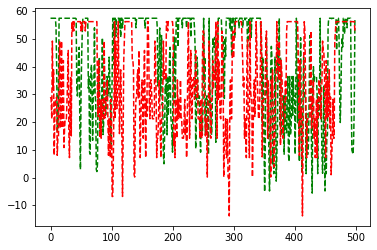

In [7]:
rewards_mean_array_ev1 = np.array(rewards_long_list_ev1[1000:1500])
x = range(rewards_mean_array_ev1.shape[0])
y1 = rewards_mean_array_ev1
rewards_mean_array_ev2 = np.array(rewards_long_list_ev2[1000:1500])
x = range(rewards_mean_array_ev2.shape[0])
y2 = rewards_mean_array_ev2
plt.plot(  x, y1, 'g--', y2, 'r--')
plt.show()

In [11]:
from scipy.io import savemat
mdic = {"agent1": y1, "agent2": y2}
savemat("testing2agent_small_scale2_non.mat", mdic)